In [1]:
"""
Simple tester for the vgg19_trainable
"""
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

import vgg16_trainable as vgg16
import os
import time
import numpy as np
from IPython.display import clear_output
import sys

PRETRAINED_MODEL_PATH= None #"/home/sik4hi/ckpt_dir"
N_EPOCHS = 300
INIT_LEARNING_RATE = 0.01
WEIGHT_DECAY_RATE = 0.0005
MOMENTUM = 0.9
IMAGE_HEIGHT  = 224    #960
IMAGE_WIDTH   = 224    #720
NUM_CHANNELS  = 3
BATCH_SIZE = 110
N_CLASSES = 1000
DROPOUT = 0.50
ckpt_dir = "/home/sik4hi/ckpt_dir"
LOGS_PATH = '/home/sik4hi/tensorflow_logs'
WEIGHT_PATH = '.npy'
TRAINSET_PATH0 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata0.csv'
TRAINSET_PATH1 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata1.csv'
TRAINSET_PATH2 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata2.csv'
TRAINSET_PATH3 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata3.csv'
TRAINSET_PATH4 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata4.csv'
TRAINSET_PATH5 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata5.csv'
TRAINSET_PATH6 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata6.csv'
TRAINSET_PATH7 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata7.csv'
TRAINSET_PATH8 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata8.csv'
TRAINSET_PATH9 = '/mnt/data1/imagenet-data/csv-files/train/imagenetdata9.csv'

VALSET_PATH0 ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata0.csv'
VALSET_PATH1 ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata1.csv'
VALSET_PATH2 ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata2.csv'
VALSET_PATH3 ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata3.csv'
VALSET_PATH4 ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata4.csv'

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#=======================================================================================================
# Reading Training data from CSV FILE
#=======================================================================================================
with tf.device('/cpu:0'):
    csv_path = tf.train.string_input_producer([TRAINSET_PATH0, TRAINSET_PATH1
                                              , TRAINSET_PATH2, TRAINSET_PATH3,
                                               TRAINSET_PATH4, TRAINSET_PATH5
                                              , TRAINSET_PATH6, TRAINSET_PATH7, 
                                               TRAINSET_PATH8, TRAINSET_PATH9
                                              ], shuffle=True)
    textReader = tf.TextLineReader()
    _, csv_content = textReader.read(csv_path)
    im_name, im_label = tf.decode_csv(csv_content, record_defaults=[[""], [1]])

    im_content = tf.read_file(im_name)
    train_image = tf.image.decode_jpeg(im_content, channels=3)
    
    # train_image = augment(train_image)
    #size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH], tf.int32)
    #train_image = tf.image.resize_images(train_image, size)
    train_label = tf.cast(im_label, tf.int64) # unnecessary

    def _compute_longer_edge(height, width, new_shorter_edge):
        return tf.cast(width*new_shorter_edge/height, tf.int32)

    shape = tf.shape(train_image)
    height = shape[0]
    width = shape[1]
    new_shorter_edge = tf.constant(256, dtype=tf.int32)

    height_smaller_than_width = tf.less_equal(height, width)
    new_height_and_width = tf.cond(
        height_smaller_than_width,
        lambda: (new_shorter_edge, _compute_longer_edge(height, width, new_shorter_edge)),
        lambda: (_compute_longer_edge(width, height, new_shorter_edge), new_shorter_edge)
    )
    size = tf.cast([new_height_and_width[0], new_height_and_width[1]], tf.int32)
    train_image = tf.image.resize_images(train_image, size)
    size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH, 3], tf.int32)
    train_image = tf.random_crop(train_image, size)
    train_image = tf.image.random_flip_left_right(train_image)
    train_image = tf.cast(train_image, tf.float32)/255. # necessary for mapping rgb channels from 0-255 to 0-1 float.
    #train_label_batch = tf.one_hot(train_label_batch, 1000)
    train_image_batch, train_label_batch = tf.train.shuffle_batch([train_image, train_label], batch_size=BATCH_SIZE,
                                                                  capacity = 1000 + 3*BATCH_SIZE, min_after_dequeue = 1000)

    val_csv_path = tf.train.string_input_producer([VALSET_PATH0
                                                   , VALSET_PATH1,
                                                   VALSET_PATH2, VALSET_PATH3, 
                                                   VALSET_PATH4
                                                  ], shuffle=True)
    val_textReader = tf.TextLineReader()
    _, val_content = val_textReader.read(val_csv_path)
    val_image, val_label = tf.decode_csv(val_content, record_defaults=[[""], [1]])

    val_image_content = tf.read_file(val_image)
    val_image = tf.image.decode_jpeg(val_image_content, channels=3)
    

    shape = tf.shape(val_image)
    height = shape[0]
    width = shape[1]
    new_shorter_edge = tf.constant(256, dtype=tf.int32)
    height_smaller_than_width = tf.less_equal(height, width)
    new_height_and_width = tf.cond(
        height_smaller_than_width,
        lambda: (new_shorter_edge, _compute_longer_edge(height, width, new_shorter_edge)),
        lambda: (_compute_longer_edge(width, height, new_shorter_edge), new_shorter_edge)
    )
    size = tf.cast([new_height_and_width[0], new_height_and_width[1]], tf.int32)
    val_image = tf.image.resize_images(val_image, size)
    size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH, 3], tf.int32)
    val_image = tf.random_crop(val_image, size)
    #val_image = tf.image.random_flip_left_right(val_image)
    val_image = tf.cast(val_image, tf.float32) / 255. # necessary


    val_label = tf.cast(val_label, tf.int64) # unnecessary
    val_image_batch, val_label_batch = tf.train.shuffle_batch([val_image, val_label], batch_size=BATCH_SIZE,
                                                              allow_smaller_final_batch=True,
                                                              capacity = 1000 + 3*BATCH_SIZE, min_after_dequeue = 1000)

with tf.device('/gpu:0'):
   
    
    
    learning_rate = tf.placeholder(tf.float32, [])
    images_tf = tf.placeholder(tf.float32, [None, 224, 224, 3])
    labels_tf = tf.placeholder(tf.int64)
    train_mode = tf.placeholder(tf.bool)

    vgg = vgg16.Vgg16()
    vgg.build(images_tf, train_mode)
    weights_only = filter(lambda x: x.name.endswith('W:0'), tf.trainable_variables())
    for x in xrange(len(weights_only)):
        print (weights_only[x].name)
    # print number of variables used: 143667240 variables, i.e. ideal size = 548MB
    print vgg.get_var_count()


    #==============================================================================================================
    # Defining Loss, could be changed from cross entropy depending on needs. The current configuration works well on
    # multiclass (not hot-encoded vectors) prediction like ImageNET.
    #==============================================================================================================
    with tf.name_scope('Loss'):
        loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(vgg.prob, labels_tf), name='loss_tf')
        #loss_summary = tf.summary.scalar("loss", loss_tf)
        weights_only = filter( lambda x: x.name.endswith('W:0'), tf.trainable_variables())
        weight_decay = tf.reduce_sum(tf.add_n([tf.nn.l2_loss(x) for x in weights_only])) * WEIGHT_DECAY_RATE
        loss_tf2 =loss_tf + weight_decay

    # ==============================================================================================================
    # Optimizer, again it can be changed to any function provided by Tensorflow. You can simply use commented out line
    # instead of explicitly computing gradients, if you are not interested in creating summaries of gradients.
    # ==============================================================================================================
    train_op = tf.train.MomentumOptimizer(learning_rate, MOMENTUM).minimize(loss_tf2)
    #train_op = tf.train.AdamOptimizer(learning_rate=0.01,epsilon=1e-08).minimize(loss_tf)
    #optimizer = tf.train.MomentumOptimizer(learning_rate, MOMENTUM)
    #grads_and_vars = optimizer.compute_gradients(loss_tf)
    #grads_and_vars = map(
     #   lambda gv: (gv[0], gv[1]) if ('conv6' in gv[1].name or 'GAP' in gv[1].name) else (gv[0] * 0.1, gv[1]),
      #  grads_and_vars)
    #grads_and_vars = [(tf.clip_by_value(gv[0], -5., 5.), gv[1]) for gv in grads_and_vars]
    #train_op = optimizer.apply_gradients(grads_and_vars)
    #===================================================================================================================
    # Summaries for the gradients
    #===================================================================================================================
    #for var in tf.trainable_variables():
     #   tf.summary.histogram(var.op.name, var)
    #summary_op = tf.summary.merge_all()


    # ===================================================================================================================
    # Accuracy for the current batch
    # ===================================================================================================================
    correct_pred = tf.equal(tf.argmax(vgg.prob, 1), labels_tf)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

with tf.device('/cpu:0'):    
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
    saver = tf.train.Saver(max_to_keep=10)
    
with tf.device('/gpu:0'):
    sess = tf.Session()
    if PRETRAINED_MODEL_PATH:
        print "using Pretrained model"
        ckpt = tf.train.get_checkpoint_state(PRETRAINED_MODEL_PATH)
        print(ckpt)
        saver.restore(sess,ckpt.model_checkpoint_path)
    else:
        init_op = tf.group(tf.initialize_all_variables(),
                       tf.initialize_local_variables())
        sess.run(init_op)
    #print(csv_path)
    # For populating queues with batches, very important!
    threads = tf.train.start_queue_runners(sess=sess)

    loss_list, train_list, plot_loss, plot_acc , loss_list2 , val_list ,plot_loss2, plot_acc2, total_loss_list1, total_loss_list2, plot_ttloss, plot_tvloss  = [], [], [], [], [], [], [], [], [], [], [], []
    #summary_writer = tf.summary.FileWriter(LOGS_PATH, graph=tf.get_default_graph())
    steps = 1
    count = 1

    

conv1_1/conv1_1_filters_W:0
conv1_2/conv1_2_filters_W:0
conv2_1/conv2_1_filters_W:0
conv2_2/conv2_2_filters_W:0
conv3_1/conv3_1_filters_W:0
conv3_2/conv3_2_filters_W:0
conv3_3/conv3_3_filters_W:0
conv4_1/conv4_1_filters_W:0
conv4_2/conv4_2_filters_W:0
conv4_3/conv4_3_filters_W:0
conv5_1/conv5_1_filters_W:0
conv5_2/conv5_2_filters_W:0
conv5_3/conv5_3_filters_W:0
fc6/fc6_weights_W:0
fc7/fc7_weights_W:0
fc8/fc8_weights_W:0
13416


===========**Training ACCURACY**================
Epoch 1
Training Accuracy:  0.0398601
Training Loss: 6.88756
Total Training Loss: 11.0255
iteration:90===========**VALIDATION ACCURACY**================
Epoch:1
Validation Accuracy:  0.0
Validation Loss: 6.90947
Time Elapsed for Epoch:1 is 5.49243178368 minutes


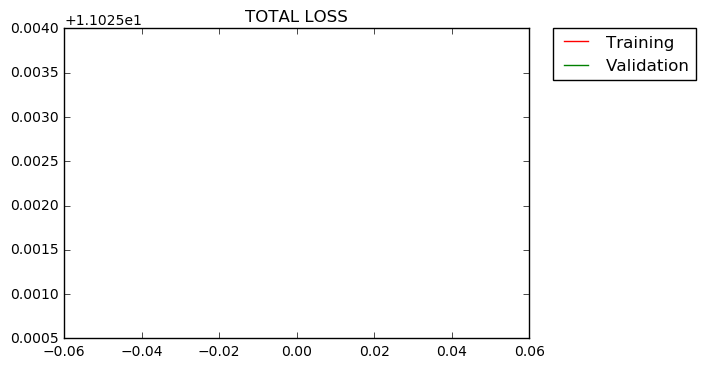

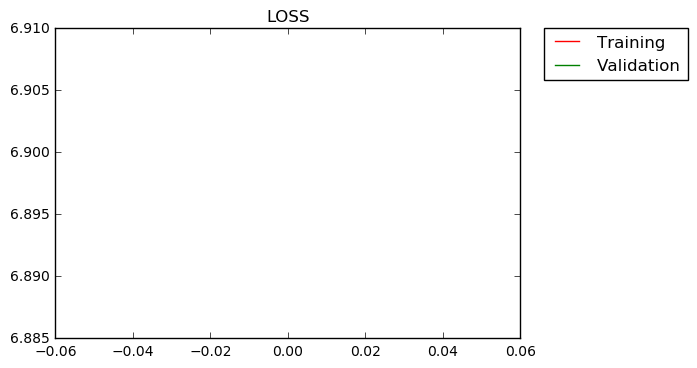

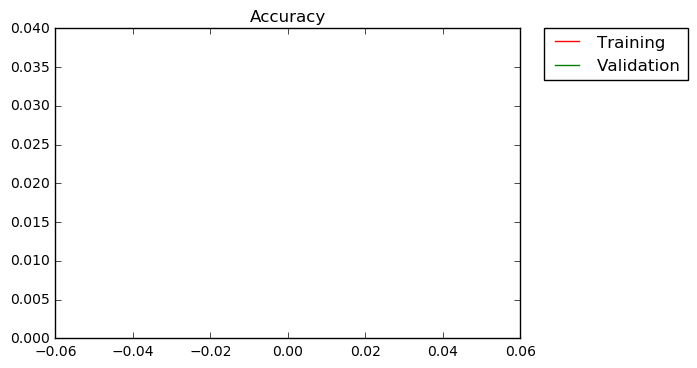

11647
iteration:26

KeyboardInterrupt: 

In [2]:
for epoch in xrange(N_EPOCHS):

        train_correct = 0
        train_data = 0
        epoch_start_time = time.time()
        print((1281144 / BATCH_SIZE) + 1)
        #print((2600 / BATCH_SIZE) + 1)
        for i in xrange((10000 / BATCH_SIZE) + 1):
            train_imbatch, train_labatch = sess.run([train_image_batch, train_label_batch])
            _, train_loss,total_loss, output_val, train_accuracy = sess.run(
               [train_op, loss_tf, loss_tf2, vgg.prob, accuracy],
               feed_dict={learning_rate: INIT_LEARNING_RATE, images_tf: train_imbatch, labels_tf:
               train_labatch, train_mode: True})

            loss_list.append(train_loss)
            train_list.append(train_accuracy)
            total_loss_list1.append(total_loss)
            sys.stdout.write('\r' + 'iteration:' + str(i))
            sys.stdout.flush()
            #train_data += len(output_val)
            

        #if (steps) % 5 == 0:  # after 5 batches
        clear_output()
        t = np.mean(train_list)
        l = np.mean(loss_list)
        ttl = np.mean(total_loss_list1)
        print "===========**Training ACCURACY**================"
        print "Epoch", epoch + 1#, "Iteration", steps
        #print "Processed", train_data, '/', 7800  # (count*BATCH_SIZE)
        print 'Training Accuracy: ', t
        #print 'labels: ', train_labatch
        
        print "Training Loss:", l 
        print "Total Training Loss:", ttl
        
        plot_loss.append(l)
        plot_acc.append(t)
        plot_ttloss.append(ttl)
      
      
                #summary_writer.add_summary(summary_str, steps)
        loss_list = []
        train_list = []
        total_loss_list1=[]
                
            
        #INIT_LEARNING_RATE *= 0.99

        for i in xrange((10000 / BATCH_SIZE) + 1 ):
            val_imbatch, val_labatch = sess.run([val_image_batch, val_label_batch])
            val_accuracy, val_loss, val_tloss = sess.run([accuracy, loss_tf, loss_tf2], feed_dict={images_tf: val_imbatch, labels_tf: val_labatch, train_mode: False})
            loss_list2.append(val_loss)
            val_list.append(val_accuracy)
            total_loss_list2.append(val_tloss)
            sys.stdout.write('\r' + 'iteration:' + str(i))
            sys.stdout.flush()
            
        t = np.mean(val_list)
        l = np.mean(loss_list2)
        tvl = np.mean(total_loss_list2)
        # #f_log.write('epoch:' + str(epoch + 1) + '\tacc:' + str(val_accuracy) + '\n')
        print "===========**VALIDATION ACCURACY**================"
        print 'Epoch:' + str(epoch + 1)# + '\tacc:' + str(val_accuracy) + '\n'
        print 'Validation Accuracy: ', t
        #print 'labels: ', train_labatch
        print "Validation Loss:", l 
        print "Total Validation Loss:", tvl
        print 'Time Elapsed for Epoch:' + str(epoch + 1) + ' is ' + str(
            (time.time() - epoch_start_time) / 60.) + ' minutes'
        plot_loss2.append(l)
        plot_acc2.append(t)
        plot_tvloss.append(tvl)
        
        plt.figure(1) 
        aa = plt.plot(plot_ttloss,'r',label="Training")
        bb = plt.plot(plot_tvloss,'g',label="Validation")
        plt.title("TOTAL LOSS")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.figure(2) 
        aa = plt.plot(plot_loss,'r',label="Training")
        bb = plt.plot(plot_loss2,'g',label="Validation")
        plt.title("LOSS")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.figure(3)
        cc = plt.plot(plot_acc,'r',label="Training")
        dd = plt.plot(plot_acc2,'g',label="Validation")
        plt.title("Accuracy")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        loss_list2 = []
        val_list = []
        total_loss_list2=[]
        if (epoch % 1 == 0):            
            saver.save(sess, ckpt_dir + "/model.ckpt", global_step=epoch)
    # test savel
    #vgg.save_npy(sess, './test-save.npy')
